# Few Shot Learning

We also examine the impact of the number of training examples on classification performance. The number of training examples
was varied from 2 to 10 in steps of 2 and the AUC evaluated for 100 training runs. In each case the rest of the class examples were
included in the test set

In [1]:
import os
import json
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# set the seed for reproducability
np.random.seed(1234)
random.seed(1234)

In [3]:
def train_test_indices(labels, num_train, sps):

    labels_array = np.array(labels)
    indices = np.arange(len(labels))
    
    train_indices = np.array([])
    test_indices = np.array([])
    for sp in sps:
        sp_indices = indices[labels_array == sp]
        train_indx, test_indx = train_test_split(sp_indices, train_size=num_train, shuffle=True)
    
        if train_indices.size:
            train_indices = np.concatenate((train_indices, train_indx))
        else:
            train_indices = train_indx
    
        if test_indices.size:
            test_indices = np.concatenate((test_indices, test_indx))
        else:
            test_indices = test_indx

    train_indices.sort()
    test_indices.sort()

    return train_indices, test_indices
            

In [4]:
embeddings_dir = '../embeddings/'
embedding_files = os.listdir(embeddings_dir)

In [5]:
with open('../annotations/single_species_filenames.json', 'r') as fp:
    single_species_filenames = json.load(fp)

## Features and labels

The 1280 dimensional embeddings are extracted from each of the 12 five second segments from the 1
minute long recordings and the mean of these embeddings are used as a feature for the recording.

We use species with more than 10 recordings

In [6]:
labels = []
mean_embeddings = np.array([])
single_species_embedding_files = [ef for ef in embedding_files if ef.replace('npz', 'mp3') in single_species_filenames.keys()]
for embedding_file in single_species_embedding_files:
    labels.append(single_species_filenames[embedding_file.replace('npz', 'mp3')])
    npzfile = np.load(os.path.join(embeddings_dir, embedding_file))
    file_embeddings = npzfile['embeddings']

    if mean_embeddings.size:
        mean_embeddings = np.vstack((mean_embeddings, np.mean(file_embeddings, 0)))
    else:
        mean_embeddings = np.mean(file_embeddings, 0)

In [7]:
label_encoder = LabelEncoder()
label_indices = label_encoder.fit_transform(labels)

label_counts = Counter(labels)
threshold = 10

filtered_labels = [label for label, count in label_counts.items() if count >= threshold]

In [8]:
new_labels = []
for label in labels:
    if label in filtered_labels:
        new_labels.append(label)
    else:
        new_labels.append('other')

In [9]:
sps = Counter(new_labels).keys()

### Few shot learning
We vary the number of training examples from 2 to 10 in steps of two and perform 100 runs each. We plot boxplots of AUC and accuracy as a function of number of traing examples.

In [10]:
num_trial = 100
np.random.seed(123)
classifier = LogisticRegression(max_iter=500)

num_train_auc = []
num_train_acc = []

for num_train in range(2, 11, 2):
    lr_auc = []
    lr_acc = []
    for trial in range(num_trial):    
        train_indices, test_indices = train_test_indices(new_labels, num_train, sps)

        X_train = mean_embeddings[train_indices,:]
        X_test = mean_embeddings[test_indices,:]

        y_train = [label for indx, label in enumerate(new_labels) if indx in train_indices] 
        y_test = [label for indx, label in enumerate(new_labels) if indx in test_indices]

        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

        macro_roc_auc_ovr = roc_auc_score(
            y_test,
            y_score,
            multi_class="ovr",
            average="macro",
        )
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        lr_auc.append(macro_roc_auc_ovr)
        lr_acc.append(accuracy)
    num_train_acc.append(lr_acc)
    num_train_auc.append(lr_auc)
                      


## Figure 9

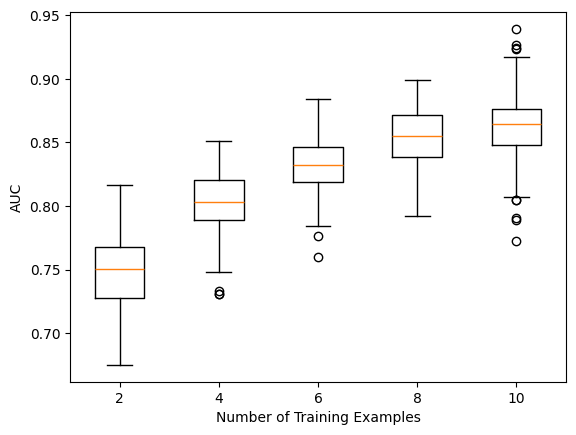

In [11]:
plt.boxplot(np.array(num_train_auc).T);
plt.xticks([1,2,3,4,5], [2,4,6,8,10]);
plt.xlabel('Number of Training Examples')
plt.ylabel('AUC')
plt.savefig('few-shot-auc.jpg', dpi=300)

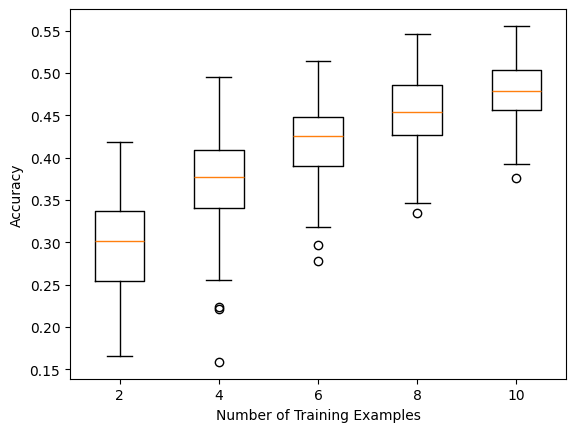

In [12]:
plt.boxplot(np.array(num_train_acc).T);
plt.xticks([1,2,3,4,5], [2,4,6,8,10]);
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.savefig('few-shot-acc.jpg', dpi=300)